<a href="https://colab.research.google.com/github/OladotunOlaiya/fault-detection/blob/main/fault-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies Importation

In [420]:
import numpy as np
from numpy.random import seed
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
#from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model,Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2,l1,l1_l2
from sklearn.model_selection import RandomizedSearchCV
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM,Input,Dense,Dropout,RepeatVector,TimeDistributed
from keras.models import Model
from keras.regularizers import l2,l1,l1_l2


In [421]:
seed(10)

## Importing data from various csv files 

In [422]:
#Mounting google drive location for the dataset
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True) 

Mounted at /content/gdrive


In [423]:
file_path ='/content/gdrive/MyDrive/Colab Notebooks/Induction_motor_faults/archive/'

In [575]:
#Bringing in the dataset into variables 
normal_files = glob.glob(file_path + "normal/**/*.csv", recursive=True)
imbalance_fault_files = glob.glob(file_path + "imbalance/**/*.csv", recursive=True)
#print the loaded csv files
print(imbalance_fault_files)

['/content/gdrive/MyDrive/Colab Notebooks/Induction_motor_faults/archive/imbalance/imbalance/6g/13.9264.csv', '/content/gdrive/MyDrive/Colab Notebooks/Induction_motor_faults/archive/imbalance/imbalance/6g/14.336.csv', '/content/gdrive/MyDrive/Colab Notebooks/Induction_motor_faults/archive/imbalance/imbalance/6g/15.36.csv', '/content/gdrive/MyDrive/Colab Notebooks/Induction_motor_faults/archive/imbalance/imbalance/6g/16.1792.csv', '/content/gdrive/MyDrive/Colab Notebooks/Induction_motor_faults/archive/imbalance/imbalance/6g/18.432.csv', '/content/gdrive/MyDrive/Colab Notebooks/Induction_motor_faults/archive/imbalance/imbalance/6g/17.408.csv', '/content/gdrive/MyDrive/Colab Notebooks/Induction_motor_faults/archive/imbalance/imbalance/6g/20.2752.csv', '/content/gdrive/MyDrive/Colab Notebooks/Induction_motor_faults/archive/imbalance/imbalance/6g/19.6608.csv', '/content/gdrive/MyDrive/Colab Notebooks/Induction_motor_faults/archive/imbalance/imbalance/6g/21.7088.csv', '/content/gdrive/MyDriv



###Downsampling:



In [576]:
#Reading in the dataset
def dataReader(files_array, output_value = 0):
    df = pd.DataFrame()
    for file in files_array:
        df_temp = pd.read_csv(file,header=None,nrows=5000)
        df = pd.concat([df,df_temp],ignore_index=True)
    df[len(df.columns)] = output_value
    return df

In [426]:
df_normal = dataReader(normal_files, 1)

In [427]:
df_normal 

,0,1,2,3,4,5,6,7,8
0,4.55950,0.175200,0.287210,-0.017751,-0.415650,0.032459,-0.11218,-0.128140,1
1,4.60380,-0.051295,-0.194050,-0.060071,-0.418090,0.036547,-0.11043,0.118310,1
2,4.57030,-0.969080,0.038033,-0.028329,-0.430810,0.041924,-0.14331,-0.071527,1
3,4.58700,0.891270,0.072973,0.007453,-0.400170,0.041090,-0.11984,0.043445,1
4,4.58870,-1.716000,-0.329290,-0.033063,-0.502810,0.040474,-0.25270,0.023901,1
...,...,...,...,...,...,...,...,...,...
244995,-0.79007,-0.700010,-0.522700,0.218520,0.086630,-0.011110,0.78143,0.027357,1
244996,-0.70602,-0.628320,-1.003300,0.081149,0.074215,-0.012323,0.70859,0.057366,1
244997,-0.71139,-0.556570,-0.058649,0.036137,0.096276,-0.008973,0.94387,-0.180240,1
244998,-0.78039,-1.210100,-1.440600,-0.020403,0.075153,-0.016513,0.72536,0.236130,1


##Data Exploration

Statistical descriptions

In [577]:
df_normal.isnull()

,0,1,2,3,4,5,6,7,8
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
244995,False,False,False,False,False,False,False,False,False
244996,False,False,False,False,False,False,False,False,False
244997,False,False,False,False,False,False,False,False,False
244998,False,False,False,False,False,False,False,False,False


In [578]:
# Missing data in columns and rows
print(df_normal.isnull().sum(axis = 0),df_normal.isnull().sum(axis = 1))

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64 0         0
1         0
2         0
3         0
4         0
         ..
244995    0
244996    0
244997    0
244998    0
244999    0
Length: 245000, dtype: int64


In [430]:
#Statistical Description
df_normal.describe()

,0,1,2,3,4,5,6,7,8
count,245000.00000,245000.000000,245000.000000,245000.000000,245000.000000,245000.000000,245000.000000,245000.000000,245000.0
mean,0.01708,0.000244,0.000144,-0.000177,0.087579,0.004566,0.083871,0.013730,1.0
std,1.73177,0.852985,0.417401,0.183672,0.626620,0.034808,0.415705,0.175754,0.0
min,-1.48330,-3.908600,-2.809900,-1.588400,-2.659300,-0.138880,-1.914700,-0.452800,1.0
25%,-0.71441,-0.566303,-0.286190,-0.086791,-0.269672,-0.021018,-0.179483,-0.123420,1.0
50%,-0.65021,0.066511,0.014194,0.000118,0.078531,0.004459,0.064588,-0.005243,1.0
75%,-0.53866,0.641235,0.300170,0.084112,0.428210,0.028287,0.336230,0.134640,1.0
max,5.04650,2.313000,3.075100,1.571900,2.613500,0.234420,2.273500,0.815130,1.0


In [ ]:
df_imbalance = dataReader(imbalance_fault_files, 0)

In [579]:
df_imbalance

,0,1,2,3,4,5,6,7,8
0,-0.59640,1.656900,0.20359,0.048174,-0.184770,-0.021301,-0.18447,-0.017205,0
1,-0.52322,-0.289020,-0.31740,-0.001449,-0.197790,-0.023694,-0.28712,-0.018203,0
2,-0.55320,1.647700,0.41715,0.038655,-0.185630,-0.021564,-0.21215,-0.072039,0
3,-0.57723,0.159140,-0.33321,-0.011148,-0.198920,-0.025401,-0.30076,-0.007373,0
4,-0.49280,1.316500,0.41147,0.028096,-0.191650,-0.022879,-0.24147,-0.108590,0
...,...,...,...,...,...,...,...,...,...
1664995,4.31670,0.459200,-0.36795,-0.303040,0.014654,-0.001740,-1.02500,-0.207670,0
1664996,4.32370,-0.524560,-1.16990,-0.288980,0.011026,-0.003344,-1.22890,0.409660,0
1664997,4.30700,0.521720,-0.42007,-0.233250,0.009568,-0.007490,-1.07090,-0.311350,0
1664998,4.32340,-0.056831,-1.35310,-0.301620,0.010415,-0.007670,-1.09820,0.324910,0


In [580]:
df_imbalance.isnull()

,0,1,2,3,4,5,6,7,8
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
1664995,False,False,False,False,False,False,False,False,False
1664996,False,False,False,False,False,False,False,False,False
1664997,False,False,False,False,False,False,False,False,False
1664998,False,False,False,False,False,False,False,False,False


In [581]:
# Missing data in columns and rows
print(df_imbalance.isnull().sum(axis = 0),df_imbalance.isnull().sum(axis = 1))

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64 0          0
1          0
2          0
3          0
4          0
          ..
1664995    0
1664996    0
1664997    0
1664998    0
1664999    0
Length: 1665000, dtype: int64


In [435]:
df_imbalance.describe()

,0,1,2,3,4,5,6,7,8
count,1.665000e+06,1.665000e+06,1.665000e+06,1.665000e+06,1.665000e+06,1.665000e+06,1.665000e+06,1.665000e+06,1665000.0
mean,3.479623e-03,6.955519e-03,-1.777688e-03,3.235746e-06,7.347689e-04,-2.209243e-03,4.855491e-02,9.779337e-03,0.0
std,1.749666e+00,9.265508e-01,1.045905e+00,3.710046e-01,2.791464e-01,3.591437e-02,1.215908e+00,7.023129e-01,0.0
min,-1.535500e+00,-4.566600e+00,-8.165500e+00,-2.216100e+00,-3.393700e+00,-2.629900e-01,-6.136100e+00,-1.554200e+02,0.0
25%,-7.521800e-01,-6.204800e-01,-5.391300e-01,-1.982400e-01,-6.012950e-02,-2.505500e-02,-6.157200e-01,-1.220800e-01,0.0
50%,-6.648900e-01,6.563000e-02,-3.771700e-03,-1.092300e-02,1.232900e-02,-1.213900e-03,1.212500e-02,-5.377100e-03,0.0
75%,-5.487000e-01,7.046000e-01,4.942200e-01,1.651300e-01,7.574400e-02,2.203000e-02,7.270900e-01,1.327900e-01,0.0
max,5.101800e+00,4.225400e+00,7.244500e+00,3.204100e+00,4.628200e+00,3.153400e-01,5.896700e+00,3.291400e+01,0.0


In [436]:
print (df_normal.shape,df_imbalance.shape)

(245000, 9) (1665000, 9)


Data visualization

*   correlation




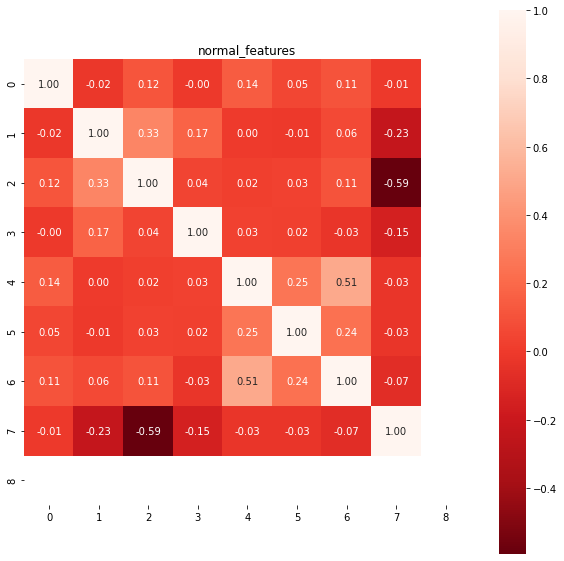

In [437]:
plt.figure(figsize=(10,10))
plt.title('normal_features')
sns.heatmap(df_normal.corr(),annot=True,fmt='.2f', square=True,cmap="Reds_r")
plt.show()

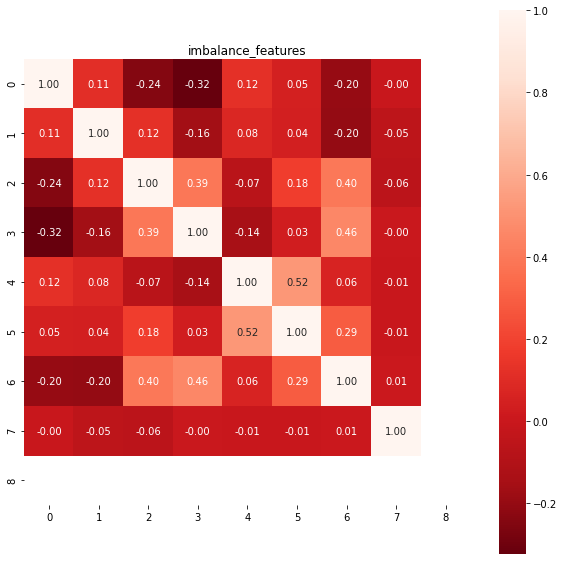

In [438]:
plt.figure(figsize=(10,10))
plt.title('imbalance_features')
sns.heatmap(df_imbalance.corr(),annot=True,fmt='.2f', square=True,cmap="Reds_r")
plt.show()

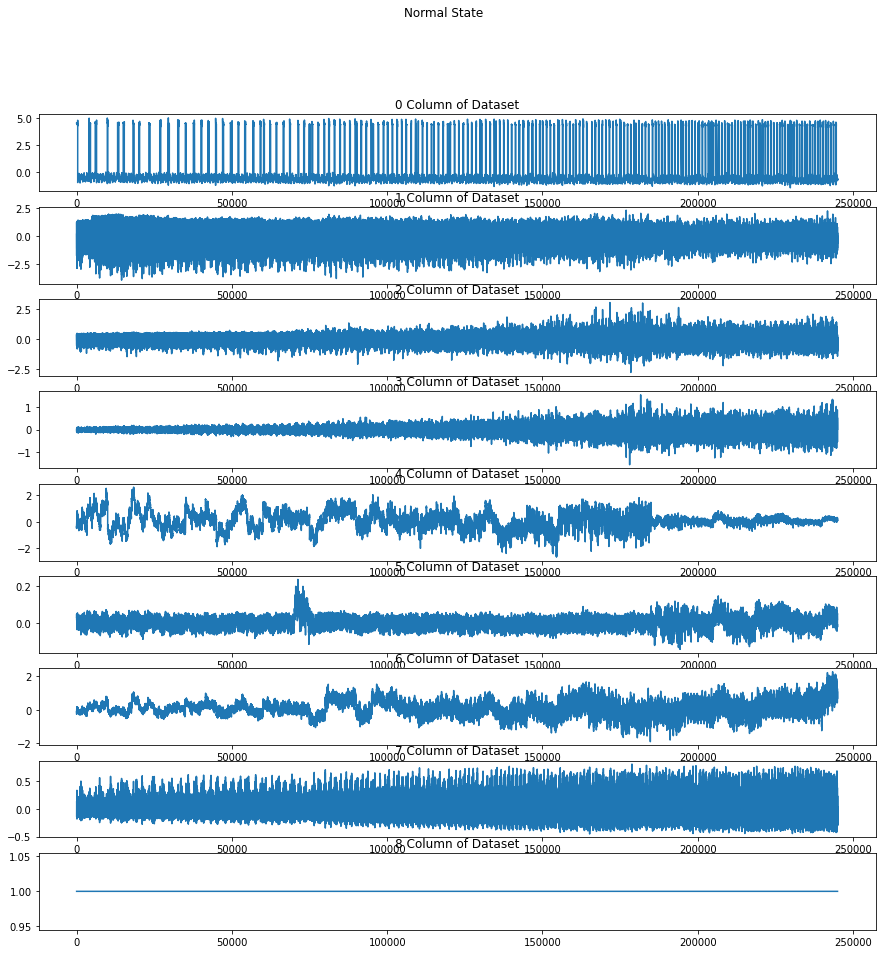

In [439]:
#Normal State Features
fig, axs = plt.subplots(9, sharex=False, sharey=False,figsize=(15,15))
fig.suptitle('Normal State')
for i in df_normal.columns:
    axs[i].plot(df_normal[i])
    axs[i].set_title('{} Column of Dataset'.format(i))

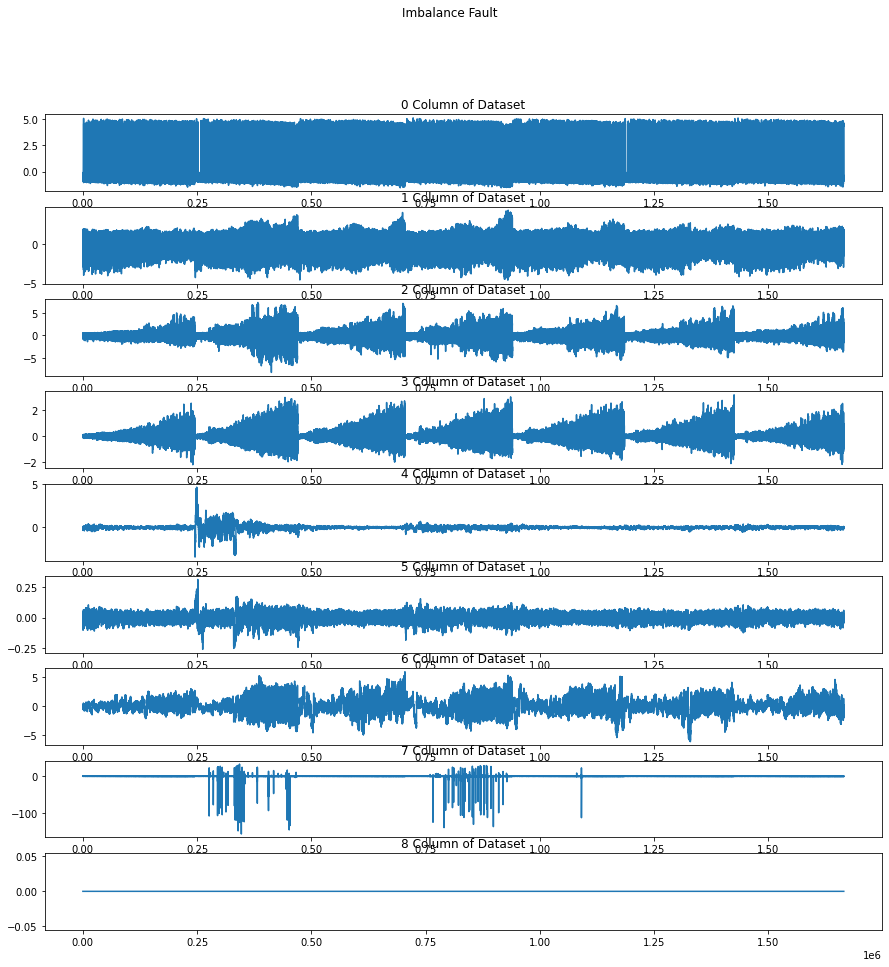

In [440]:
#imbalance features
fig, axs = plt.subplots(9, sharex=False, sharey=False,figsize=(15,15))
fig.suptitle('Imbalance Fault')
for i in df_imbalance.columns:
    axs[i].plot(df_imbalance[i])
    axs[i].set_title('{} Column of Dataset'.format(i))




*   Box Plots 




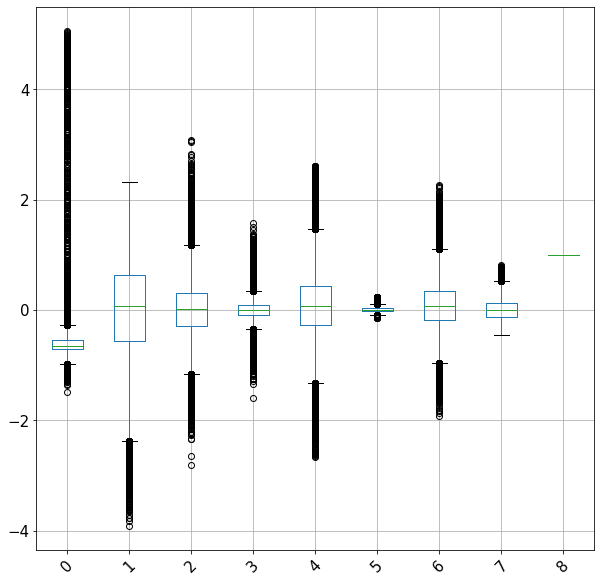

In [441]:
#Box plot for normal data before normalization
boxplot = df_normal.boxplot(rot=45, fontsize=15,figsize=(10,10))

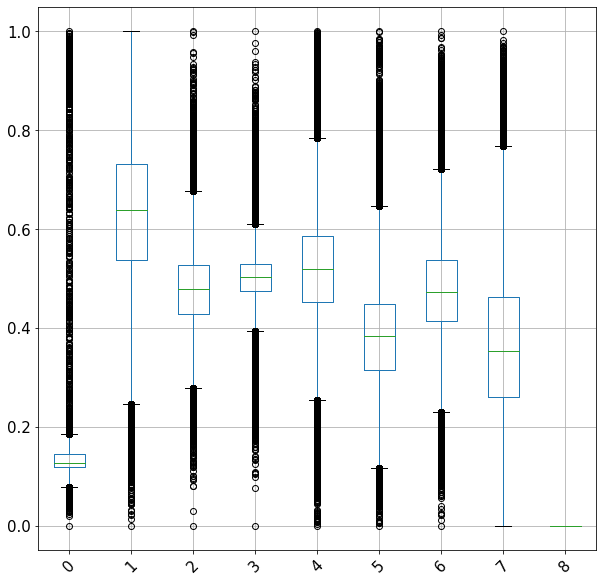

In [442]:
#after scaling:
scaler = MinMaxScaler()
scaled_df_normal = scaler.fit_transform(df_normal)
boxplot = pd.DataFrame(scaled_df_normal).boxplot(rot=45, fontsize=15,figsize=(10,10))

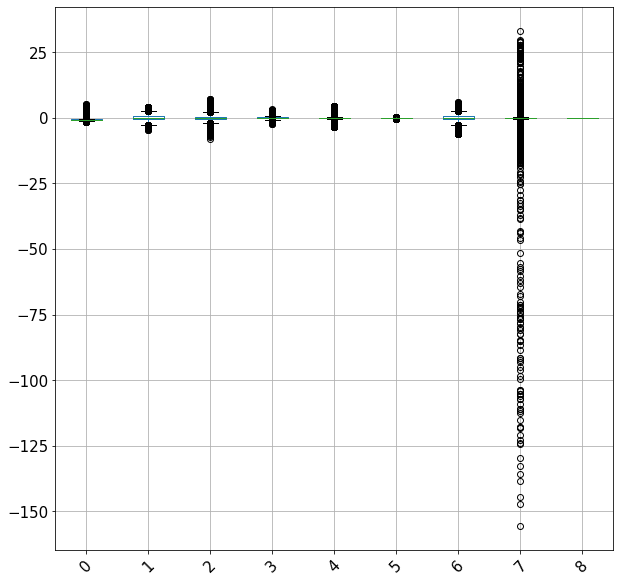

In [443]:
#Box plot for imbalance data before normalization
boxplot = df_imbalance.boxplot(rot=45, fontsize=15,figsize=(10,10))

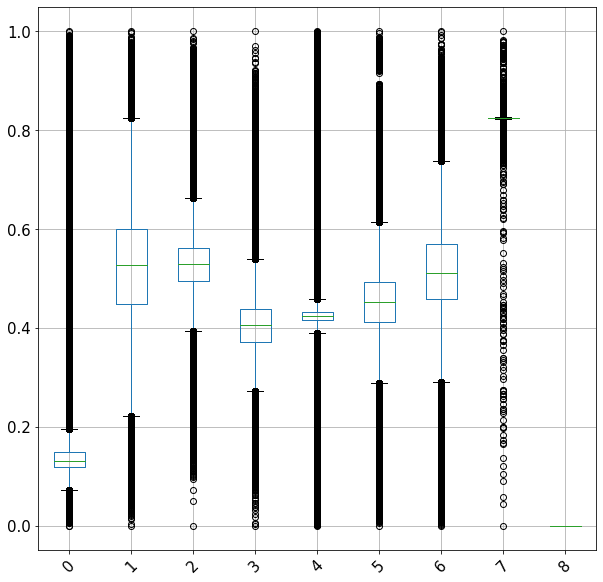

In [444]:
#after scaling:
scaler = MinMaxScaler()
scaled_df_imbalance = scaler.fit_transform(df_imbalance)
boxplot = pd.DataFrame(scaled_df_imbalance).boxplot(rot=45, fontsize=15,figsize=(10,10))


## Data Preprocessing

*   Combining both normal and Imbalance data:




In [445]:
#Join normal and imbalance data frames
df_combined = pd.concat([df_normal,df_imbalance],ignore_index=True)
df_combined.columns=['SV0','SV1','SV2','SV3','SV4','SV5','SV6','SV7','Y'] # sensor values
df_combined_no_label = df_combined.values[:, 0:-1]
df_combined.index=pd.to_datetime(df_combined.index,format='%Y-%m-%d %H:%M:%S')# assume data point was generated every 
df_combined=df_combined.sort_index()

labels =df_combined.values[:, -1]
df_combined_no_label = df_combined.values[:, 0:-1]



In [446]:
df_combined

,SV0,SV1,SV2,SV3,SV4,SV5,SV6,SV7,Y
1970-01-01 00:00:00.000000000,4.5595,0.175200,0.287210,-0.017751,-0.415650,0.032459,-0.11218,-0.128140,1
1970-01-01 00:00:00.000000001,4.6038,-0.051295,-0.194050,-0.060071,-0.418090,0.036547,-0.11043,0.118310,1
1970-01-01 00:00:00.000000002,4.5703,-0.969080,0.038033,-0.028329,-0.430810,0.041924,-0.14331,-0.071527,1
1970-01-01 00:00:00.000000003,4.5870,0.891270,0.072973,0.007453,-0.400170,0.041090,-0.11984,0.043445,1
1970-01-01 00:00:00.000000004,4.5887,-1.716000,-0.329290,-0.033063,-0.502810,0.040474,-0.25270,0.023901,1
...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.001909995,4.3167,0.459200,-0.367950,-0.303040,0.014654,-0.001740,-1.02500,-0.207670,0
1970-01-01 00:00:00.001909996,4.3237,-0.524560,-1.169900,-0.288980,0.011026,-0.003344,-1.22890,0.409660,0
1970-01-01 00:00:00.001909997,4.3070,0.521720,-0.420070,-0.233250,0.009568,-0.007490,-1.07090,-0.311350,0
1970-01-01 00:00:00.001909998,4.3234,-0.056831,-1.353100,-0.301620,0.010415,-0.007670,-1.09820,0.324910,0


In [447]:
df_combined_no_label

array([[ 4.5595   ,  0.1752   ,  0.28721  , ...,  0.032459 , -0.11218  ,
        -0.12814  ],
       [ 4.6038   , -0.051295 , -0.19405  , ...,  0.036547 , -0.11043  ,
         0.11831  ],
       [ 4.5703   , -0.96908  ,  0.038033 , ...,  0.041924 , -0.14331  ,
        -0.071527 ],
       ...,
       [ 4.307    ,  0.52172  , -0.42007  , ..., -0.0074902, -1.0709   ,
        -0.31135  ],
       [ 4.3234   , -0.056831 , -1.3531   , ..., -0.0076699, -1.0982   ,
         0.32491  ],
       [ 4.305    ,  0.61926  , -0.771    , ..., -0.0088764, -1.0669   ,
        -0.22678  ]])



*   Split the separate data into train and test:




In [448]:
Normal_data=df_combined_no_label[0:245000]# normal data 
Normal_labels=labels[0:245000]
Imablance_data=df_combined_no_label[245000:]# take 20% of the imbalance data for validation
Imbalance_labels=labels[245000:]
Normal_data.shape,Imablance_data.shape,Normal_labels.shape,Imbalance_labels.shape


((245000, 8), (1665000, 8), (245000,), (1665000,))


 

* Split normal into train and test:    









In [449]:
#Normal train and test
xtrain_normal,x_test_normal,ytrain_normal,ytest_normal=train_test_split(Normal_data,Normal_labels,test_size=0.2,random_state=0)
xtrain_normal.shape,ytrain_normal.shape,x_test_normal.shape,ytest_normal.shape

((196000, 8), (196000,), (49000, 8), (49000,))

* Split imbalance into train and test: 

In [450]:
#imbalance data
xtrain_imbal,x_test_imbal,ytrain_imbal,ytest_imbal=train_test_split(Imablance_data,Imbalance_labels,test_size=0.2,random_state=0)
xtrain_imbal.shape,ytrain_imbal.shape,x_test_imbal.shape,ytest_imbal.shape

((1332000, 8), (1332000,), (333000, 8), (333000,))

* Split the combined into train and test: 

In [451]:
#combined data
train_combined,test_combined,ytrain_combined,ytest_combined =train_test_split(df_combined_no_label,labels,test_size=0.2,random_state=20)
train_combined.shape,test_combined.shape,ytrain_combined.shape,ytest_combined.shape


((1528000, 8), (382000, 8), (1528000,), (382000,))



*  Scaling and Reshaping the normal data into a tensor:




In [544]:
#for the normal data:
scaler=MinMaxScaler()
x_trainN_scaled=scaler.fit_transform(xtrain_normal)

x_testN_scaled=scaler.transform(x_test_normal)
x_train_2d=x_trainN_scaled
x_trainN_scaled=x_trainN_scaled.reshape(x_trainN_scaled.shape[0],1,x_trainN_scaled.shape[1])
print('normal training data shape:',x_trainN_scaled.shape)
x_testN_scaled=x_testN_scaled.reshape(x_testN_scaled.shape[0],1,x_testN_scaled.shape[1])
print('normal testing data shape:',x_testN_scaled.shape)

normal training data shape: (196000, 1, 8)
normal testing data shape: (49000, 1, 8)



*  Scaling and Reshaping the imbal data into a tensor:

In [453]:
#for the imbalance data:
scaler=MinMaxScaler()
x_train_imbal_scaled=scaler.fit_transform(xtrain_imbal)
x_test_imbal_scaled=scaler.transform(x_test_imbal)
x_train_imbal_scaled=x_train_imbal_scaled.reshape(x_train_imbal_scaled.shape[0],1,x_train_imbal_scaled.shape[1])
print('imbalance training data shape:',x_train_imbal_scaled.shape)
x_test_imbal_scaled=x_test_imbal_scaled.reshape(x_test_imbal_scaled.shape[0],1,x_test_imbal_scaled.shape[1])
print('imbalance testing data shape:',x_test_imbal_scaled.shape)

imbalance training data shape: (1332000, 1, 8)
imbalance testing data shape: (333000, 1, 8)



*  Scaling and Reshaping the combined data into a tensor:

In [454]:
#for the combined data:
scaler=MinMaxScaler()
train_combined_scaled=scaler.fit_transform(train_combined)
test_combined_scaled=scaler.transform(test_combined)
train_combined_scaled=train_combined_scaled.reshape(train_combined_scaled.shape[0],1,train_combined_scaled.shape[1])
test_combined_scaled=test_combined_scaled.reshape(test_combined_scaled.shape[0],1,test_combined_scaled.shape[1])
test_combined_scaled.shape

(382000, 1, 8)

# LSTM autoencoder model:

In [571]:
def LSTM_autoencoder(X=x_trainN_scaled,activation='relu',kernel_regularizer=regularizers.L2(0.00)):
    print(X.shape)
    inputs=Input(shape=(X.shape[1],X.shape[2]))
    x=inputs
    x=LSTM(16,activation='relu',return_sequences=True,kernel_regularizer=regularizers.L2(0.00))(x)
    x=LSTM(4,activation='relu',return_sequences=False)(x)
    x=RepeatVector(X.shape[1])(x)
    x=LSTM(4,activation='relu',return_sequences=True)(x)
    x=LSTM(16,activation='relu',return_sequences=True)(x)
    output=TimeDistributed(Dense(X.shape[2]))(x)
    model=Model(inputs=inputs,outputs=output)
    model.compile(optimizer='adam',loss='mae',metrics=["accuracy"])
    return model



*   Hyperparameter tuning with Randomsearch
 



In [572]:
model=KerasClassifier(build_fn=LSTM_autoencoder,verbose=1)

kernel_regularizer=['L1','L2']
epochs=[20,50,100,150]
batch_size=[32,64,128,512]
activation=['relu','tanh']
param_grid=dict(batch_size=batch_size,activation=activation,kernel_regularizer=kernel_regularizer,epochs=epochs)
grid=RandomizedSearchCV(estimator=model,param_distributions=param_grid,n_jobs=-1,cv=3,n_iter=5)

In [573]:
grid_result=grid.fit(x_trainN_scaled,x_train_2d)
print("Best: %f using %s" %(grid_result.best_score_,grid_result.best_params_))

(196000, 1, 8)
Epoch 1/100
6125/6125 [==============================] - 28s 4ms/step - loss: 0.1182 - accuracy: 4.7805e-06
Epoch 2/100
6125/6125 [==============================] - 22s 4ms/step - loss: 0.0856 - accuracy: 5.7606e-06
Epoch 3/100
6125/6125 [==============================] - 21s 3ms/step - loss: 0.0855 - accuracy: 3.0683e-06
Epoch 4/100
6125/6125 [==============================] - 22s 4ms/step - loss: 0.0854 - accuracy: 3.7244e-06
Epoch 5/100
6125/6125 [==============================] - 22s 4ms/step - loss: 0.0854 - accuracy: 2.3751e-06
Epoch 6/100
6125/6125 [==============================] - 21s 4ms/step - loss: 0.0856 - accuracy: 3.3238e-06
Epoch 7/100
6125/6125 [==============================] - 22s 4ms/step - loss: 0.0854 - accuracy: 3.0489e-06
Epoch 8/100
6125/6125 [==============================] - 21s 3ms/step - loss: 0.0853 - accuracy: 4.1591e-06
Epoch 9/100
6125/6125 [==============================] - 21s 3ms/step - loss: 0.0856 - accuracy: 3.7590e-06
Epoch 10/100


## create and compile the model

In [458]:
model=LSTM_autoencoder(x_trainN_scaled)
model.compile(optimizer='adam',loss='mae')
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 1, 8)]            0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 1, 16)             1600      
_________________________________________________________________
lstm_57 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_14 (RepeatVect (None, 1, 4)              0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_59 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 1, 8)              136

## Model Training:

In [459]:
#training the model:
epochs_number=20
batch_size=512
history = model.fit(x_trainN_scaled,x_trainN_scaled,epochs=epochs_number,batch_size=batch_size,validation_data=(test_combined_scaled,test_combined_scaled),shuffle=True,verbose=1)

Epoch 1/20
383/383 [==============================] - 14s 18ms/step - loss: 0.2849 - val_loss: 0.1398
Epoch 2/20
383/383 [==============================] - 5s 13ms/step - loss: 0.0763 - val_loss: 0.0913
Epoch 3/20
383/383 [==============================] - 5s 13ms/step - loss: 0.0622 - val_loss: 0.0897
Epoch 4/20
383/383 [==============================] - 5s 14ms/step - loss: 0.0600 - val_loss: 0.0933
Epoch 5/20
383/383 [==============================] - 5s 14ms/step - loss: 0.0493 - val_loss: 0.0902
Epoch 6/20
383/383 [==============================] - 6s 14ms/step - loss: 0.0462 - val_loss: 0.0870
Epoch 7/20
383/383 [==============================] - 6s 15ms/step - loss: 0.0451 - val_loss: 0.0845
Epoch 8/20
383/383 [==============================] - 5s 14ms/step - loss: 0.0443 - val_loss: 0.0818
Epoch 9/20
383/383 [==============================] - 6s 15ms/step - loss: 0.0438 - val_loss: 0.0782
Epoch 10/20
383/383 [==============================] - 6s 15ms/step - loss: 0.0433 - val_l

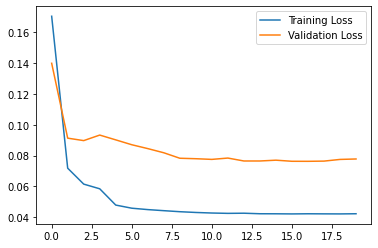

In [460]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [461]:
reconstructions = model.predict(x_trainN_scaled)
train_loss = tf.keras.losses.mae(reconstructions, x_trainN_scaled)

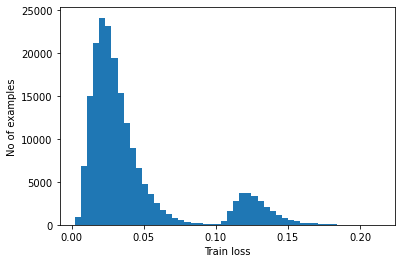

In [462]:
plt.hist(train_loss[:,0], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()



## Setting threshold




In [488]:
threshold = np.mean(train_loss) #+ np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.042188457100542864


In [489]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  #print("Precision = {}".format(precision_score(labels, predictions)))
  #print("Recall = {}".format(recall_score(labels, predictions)))

In [490]:
def predictLabels(autoEncoderModel, inputData, threshold_val):
  recon = autoEncoderModel(inputData)
  loss_val = tf.keras.losses.mae(recon, inputData)
  predictedLabels = tf.math.less(loss_val, threshold_val)
  return predictedLabels, loss_val

def print_stats_new(predicted_val, inputDataLabels):
  print("Accuracy = {}".format(accuracy_score(inputDataLabels, predicted_val)))

## Prediction accuracy( Not the model accuracy)

In [510]:
preds_val, loss_values = predictLabels(model, test_combined_scaled, threshold)

print_stats_new(preds_val, ytest_combined)

Accuracy = 0.8233246073298429


In [516]:
preds_val_normal, loss_values_normal = predictLabels(model, x_trainN_scaled, threshold)

In [517]:
print_stats_new(preds_val_normal, ytrain_normal)

Accuracy = 0.7271632653061224


In [509]:
preds_val_imbalance, loss_values_imbalance = predictLabels(model, x_train_imbal_scaled, threshold)

In [ ]:
time = np.linspace(0,1,len(test_combined_scaled),endpoint=True)
fig, axs = plt.subplots(nrows=1, figsize=(16, 9))

#sns.lineplot(x=time, y=loss_values)
#plt.plot(loss_values_imbalance[:250], label="loss value", color='r')
#plt.plot(loss_values_normal[:250], label="normal loss value", color='g')
#plt.plot([100, threshold], label="Threshold Value")

#plt.axhline(y=threshold, label="Threshold Value", color='b')
#plt.show()

In [471]:
preds = predict(model, test_combined_scaled, threshold)
print_stats(preds, ytest_combined)
#preds

Accuracy = 0.8233246073298429


In [472]:
preds.shape,x_test_imbal_scaled.shape,ytest_imbal.shape

(TensorShape([382000, 1]), (333000, 1, 8), (333000,))

In [473]:
#x_test_imbal_scaled.shape[0]

preds[0]

preds.numpy()

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [474]:
#pred_scaled=pd.DataFrame(x_test_imbal_scaled[:,0]) + pd.DataFrame(ytest_imbal[:])

#pred_scaled = pd.concat([pd.DataFrame(x_test_imbal_scaled[:,0]), pd.DataFrame(ytest_imbal[:]), pd.DataFrame(preds.numpy())], axis=1, ignore_index=True)
pred_scaled = pd.concat([pd.DataFrame(test_combined_scaled[:,0]), pd.DataFrame(ytest_combined[:].astype(int)), pd.DataFrame(preds.numpy().astype(int))], axis=1, ignore_index=True)
#pred_scaled=pd.DataFrame(x_test_imbal_scaled[:,0])

#pd.DataFrame.set_index()

In [475]:
pred_scaled

#pred_scaled

#ytest_imbal

,0,1,2,3,4,5,6,7,8,9
0,0.889598,0.485373,0.295224,0.314709,0.433262,0.478552,0.376089,0.826734,0,0
1,0.096892,0.363262,0.543093,0.391013,0.382229,0.348756,0.261776,0.824665,0,0
2,0.142646,0.466899,0.474125,0.351542,0.428773,0.456325,0.482137,0.824682,0,0
3,0.130370,0.439210,0.545020,0.418715,0.425847,0.424821,0.418265,0.825389,0,0
4,0.094795,0.559699,0.609753,0.302330,0.433641,0.444319,0.457916,0.824313,0,0
...,...,...,...,...,...,...,...,...,...,...
381995,0.147690,0.509596,0.484689,0.460448,0.384547,0.342597,0.447961,0.826100,1,1
381996,0.130787,0.427343,0.570947,0.373811,0.429208,0.487251,0.502849,0.826279,0,0
381997,0.139707,0.388421,0.518661,0.405389,0.438278,0.528543,0.523476,0.826294,0,0
381998,0.150514,0.625661,0.543778,0.350408,0.435357,0.534423,0.496569,0.824686,0,0


In [476]:
true_count = (pred_scaled[9]).value_counts()[1] 
False_count = (pred_scaled[9]).value_counts()[0]
print(true_count,False_count)

20791 361209


In [477]:
#accuracy_count = (pred_scaled[8]).value_counts()

accuracy_count = (pred_scaled[pred_scaled[8] == pred_scaled[9]]).value_counts()
#true_count_2 = accuracy_count[10].value_counts()[True]
print(len(accuracy_count))

314510


In [478]:
p=(len(accuracy_count)/len(pred_scaled))*100
print(p)

82.33246073298429
